# Data Preprocess

## Importar librerias

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
from scipy.stats import yeojohnson

from src.features.plots import *
from src.features.functions import percentile_range_data
from src.features.new_or_used import build_dataset
from src.features.data_preprocessing import preprocess_dataset
from src.features.data_process import DataScaler

pd.set_option('display.max_columns', None)

## Importar datos

In [2]:
# Import the data and convert it into dataframes for easier manipulation.
MAKE_DATASET = False
if MAKE_DATASET:
    X_train, y_train, X_test, y_test = build_dataset()

    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    y_train.columns = ['condition']
    y_test.columns = ['condition']

    train_data, train_target = preprocess_dataset(X_train,y_train,del_na=True)
    test_data, test_target = preprocess_dataset(X_test,y_test,del_na=True)

    train_data.to_csv("../data/staging/train_data.csv", index=False)
    train_target.to_csv("../data/staging/train_target.csv", index=False)
    test_data.to_csv("../data/staging/test_data.csv", index=False)
    test_target.to_csv("../data/staging/test_target.csv", index=False)

else:
    train_data = pd.read_csv("../data/staging/train_data.csv")
    train_target = pd.read_csv("../data/staging/train_target.csv")
    test_data = pd.read_csv("../data/staging/test_data.csv")
    test_target = pd.read_csv("../data/staging/test_target.csv")

In [3]:
df = pd.concat([train_data, train_target], axis=1).copy(deep=True)
df_2 = pd.concat([test_data, test_target], axis=1).copy(deep=True)

### Data Exploration Analisis (DAE)

In [4]:
target_column = ["is_new"]
numeric_columns = ['price','initial_quantity','sold_quantity','available_quantity','days_active','num_pictures']
date_columns = ["start_week", "start_day", "stop_week", "stop_day"]
bool_columns = ['price_in_usd', 'warranty_info', 'mode_buy_it_now', 'mode_classified','mode_auction', 'cash_payment', 'card_payment', 'bank_payment','mercadopago_payment','agree_with_buyer_payment','shipping_me1','shipping_me2', 'shipping_custom', 'shipping_not_specified','free_shipping', 'local_pick_up', 'buenos_aires_seller', 'listing_free','listing_bronze', 'listing_silver','listing_gold', 'is_active', 'automatic_relist', 'dragged_bids_or_visits']

### Bool columns

In this phase of our analysis, we embark on an examination of the distribution patterns exhibited by binary categorical variables within our dataset. The exploration of these variables serves as a crucial step in understanding the fundamental characteristics and potential insights they may provide.

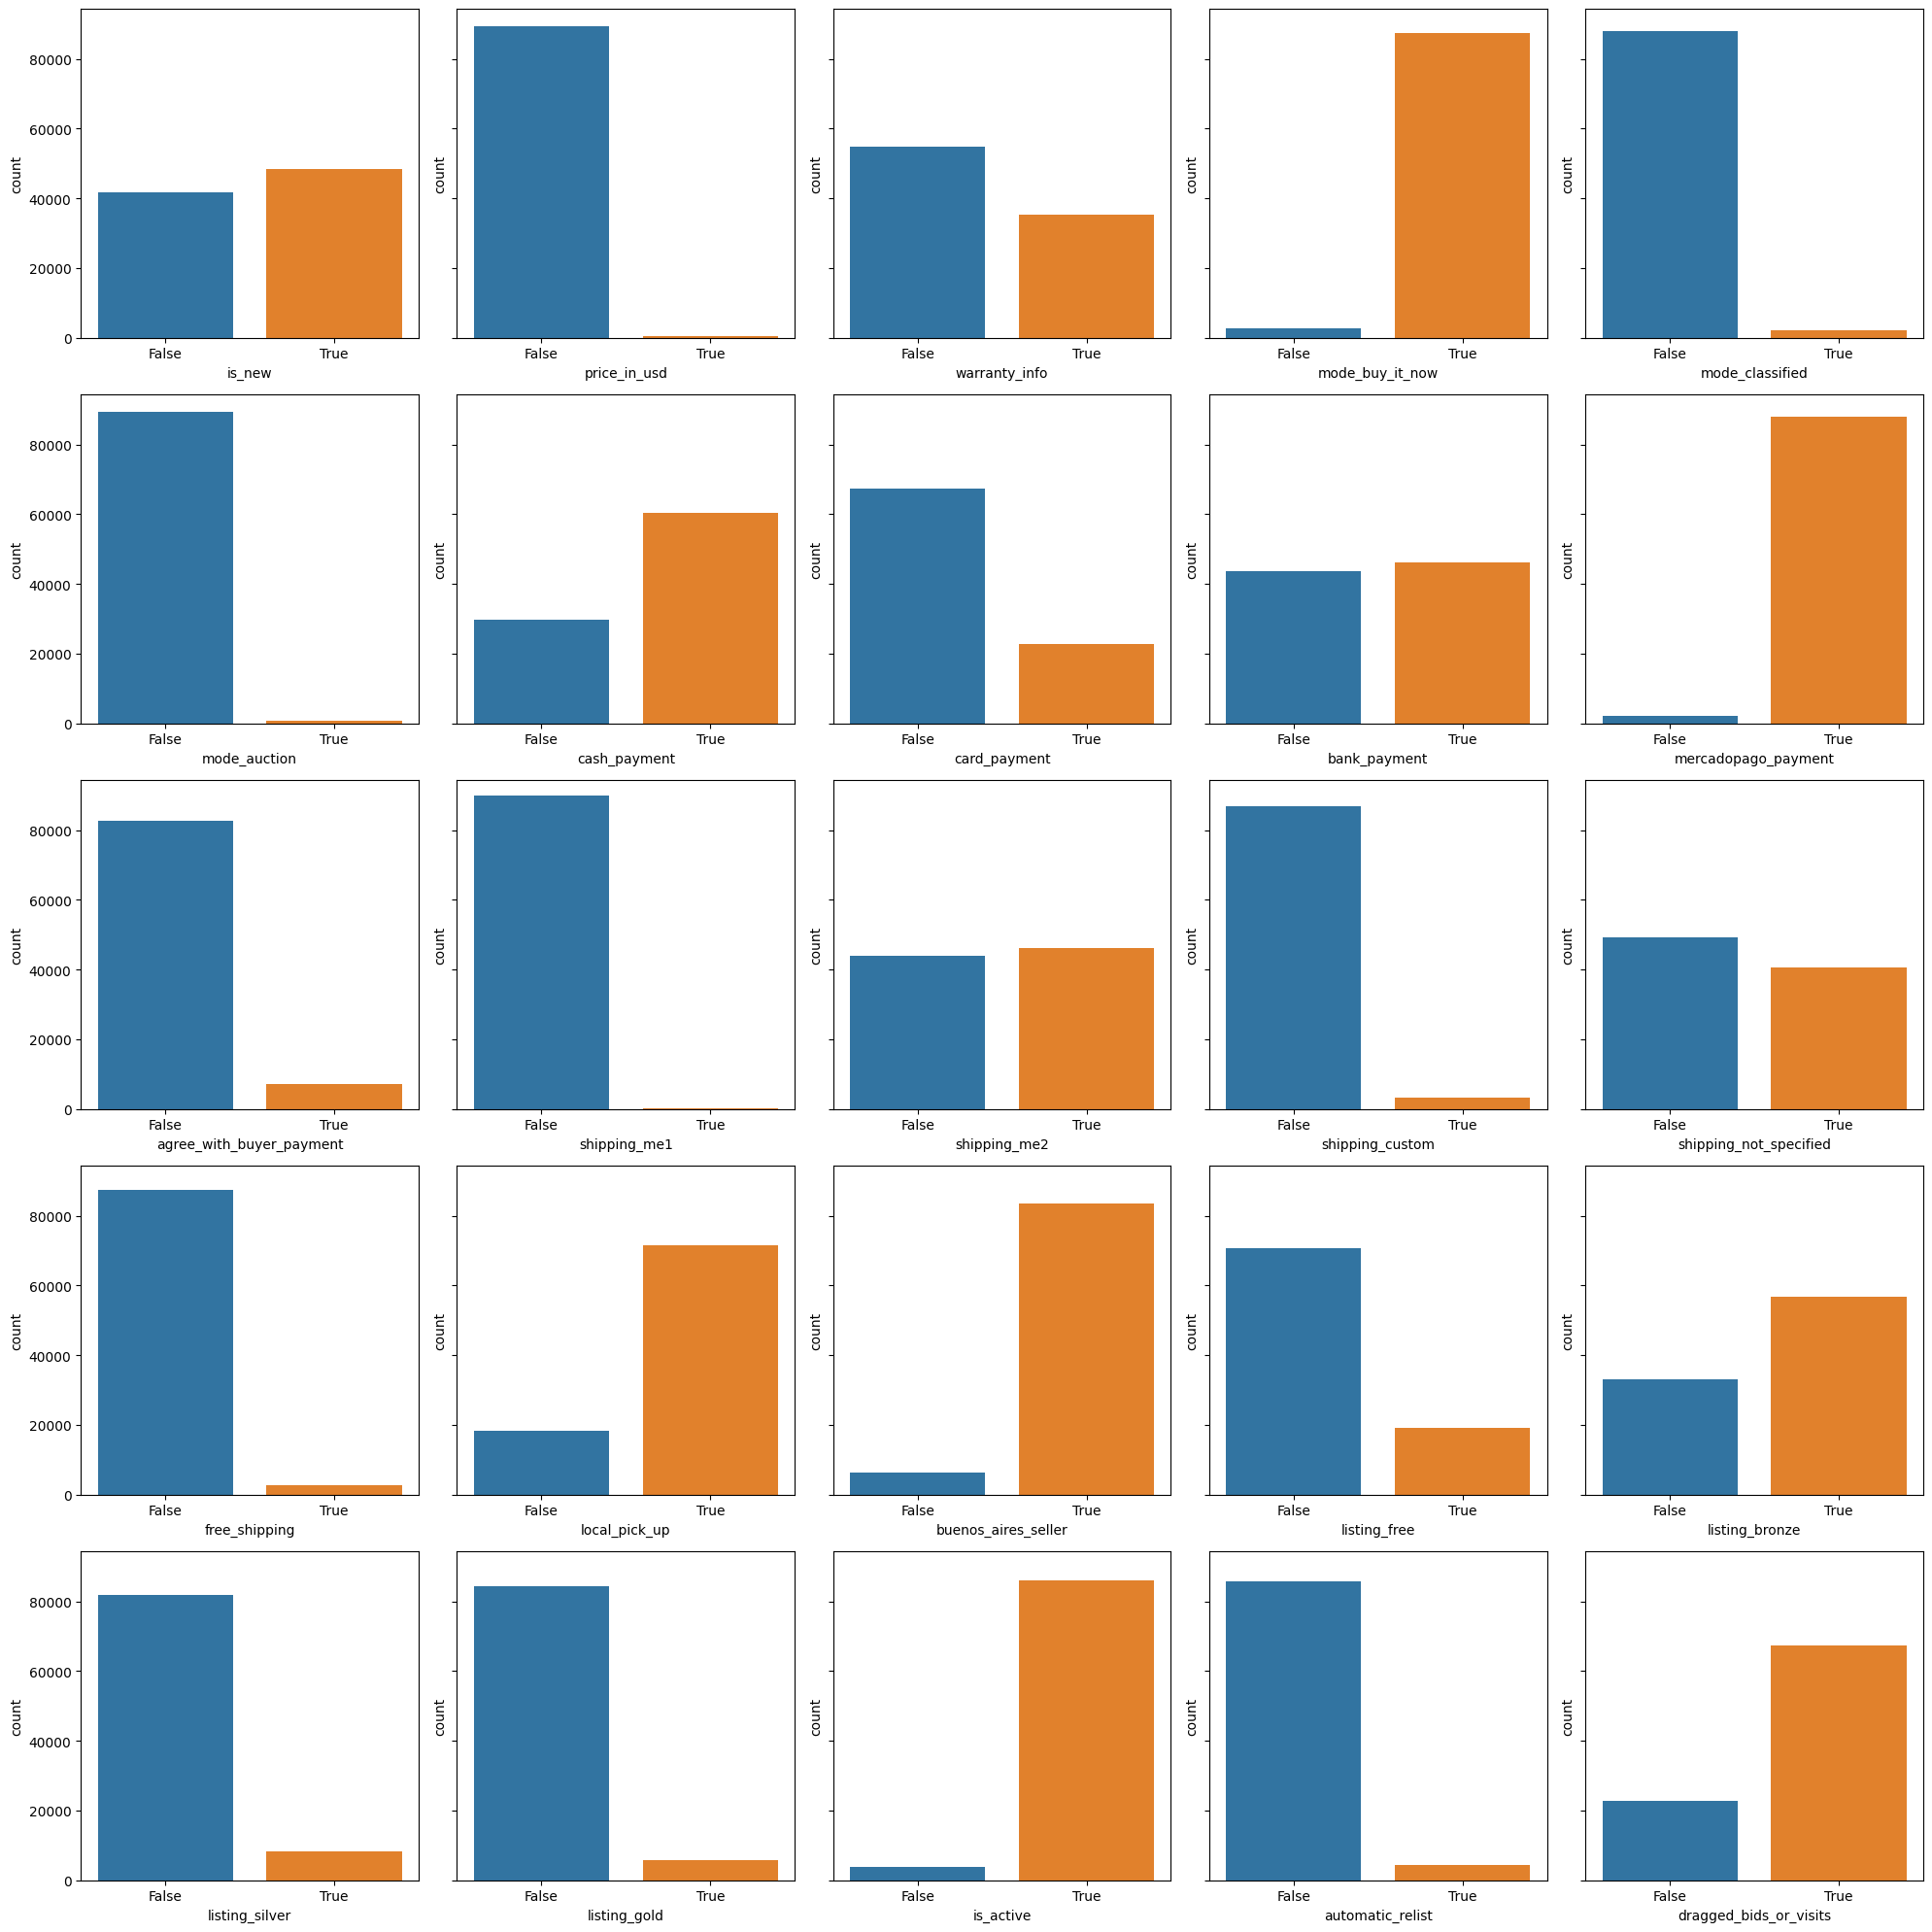

In [5]:
create_subplots(binary_countplot_function, df, target_column + bool_columns, num_rows=5, num_cols=5, fig_size=(20, 20),share_y=True)

The generated heatmap, produced by the boolean_correlation_heatmap_function(), illustrates the correlation between two boolean columns within a dataset. It represents a correlation matrix where each cell corresponds to a pair of states from the two boolean variables. It facilitates the identification of patterns and relationships between them within the dataset.

Interpretation:

- Higher values signify a higher proportion of cases where both boolean variables share the same state, implying a stronger correlation.
- Lower values indicate a weaker correlation between the states of the two variables.

Is sensitive to data imbalance.


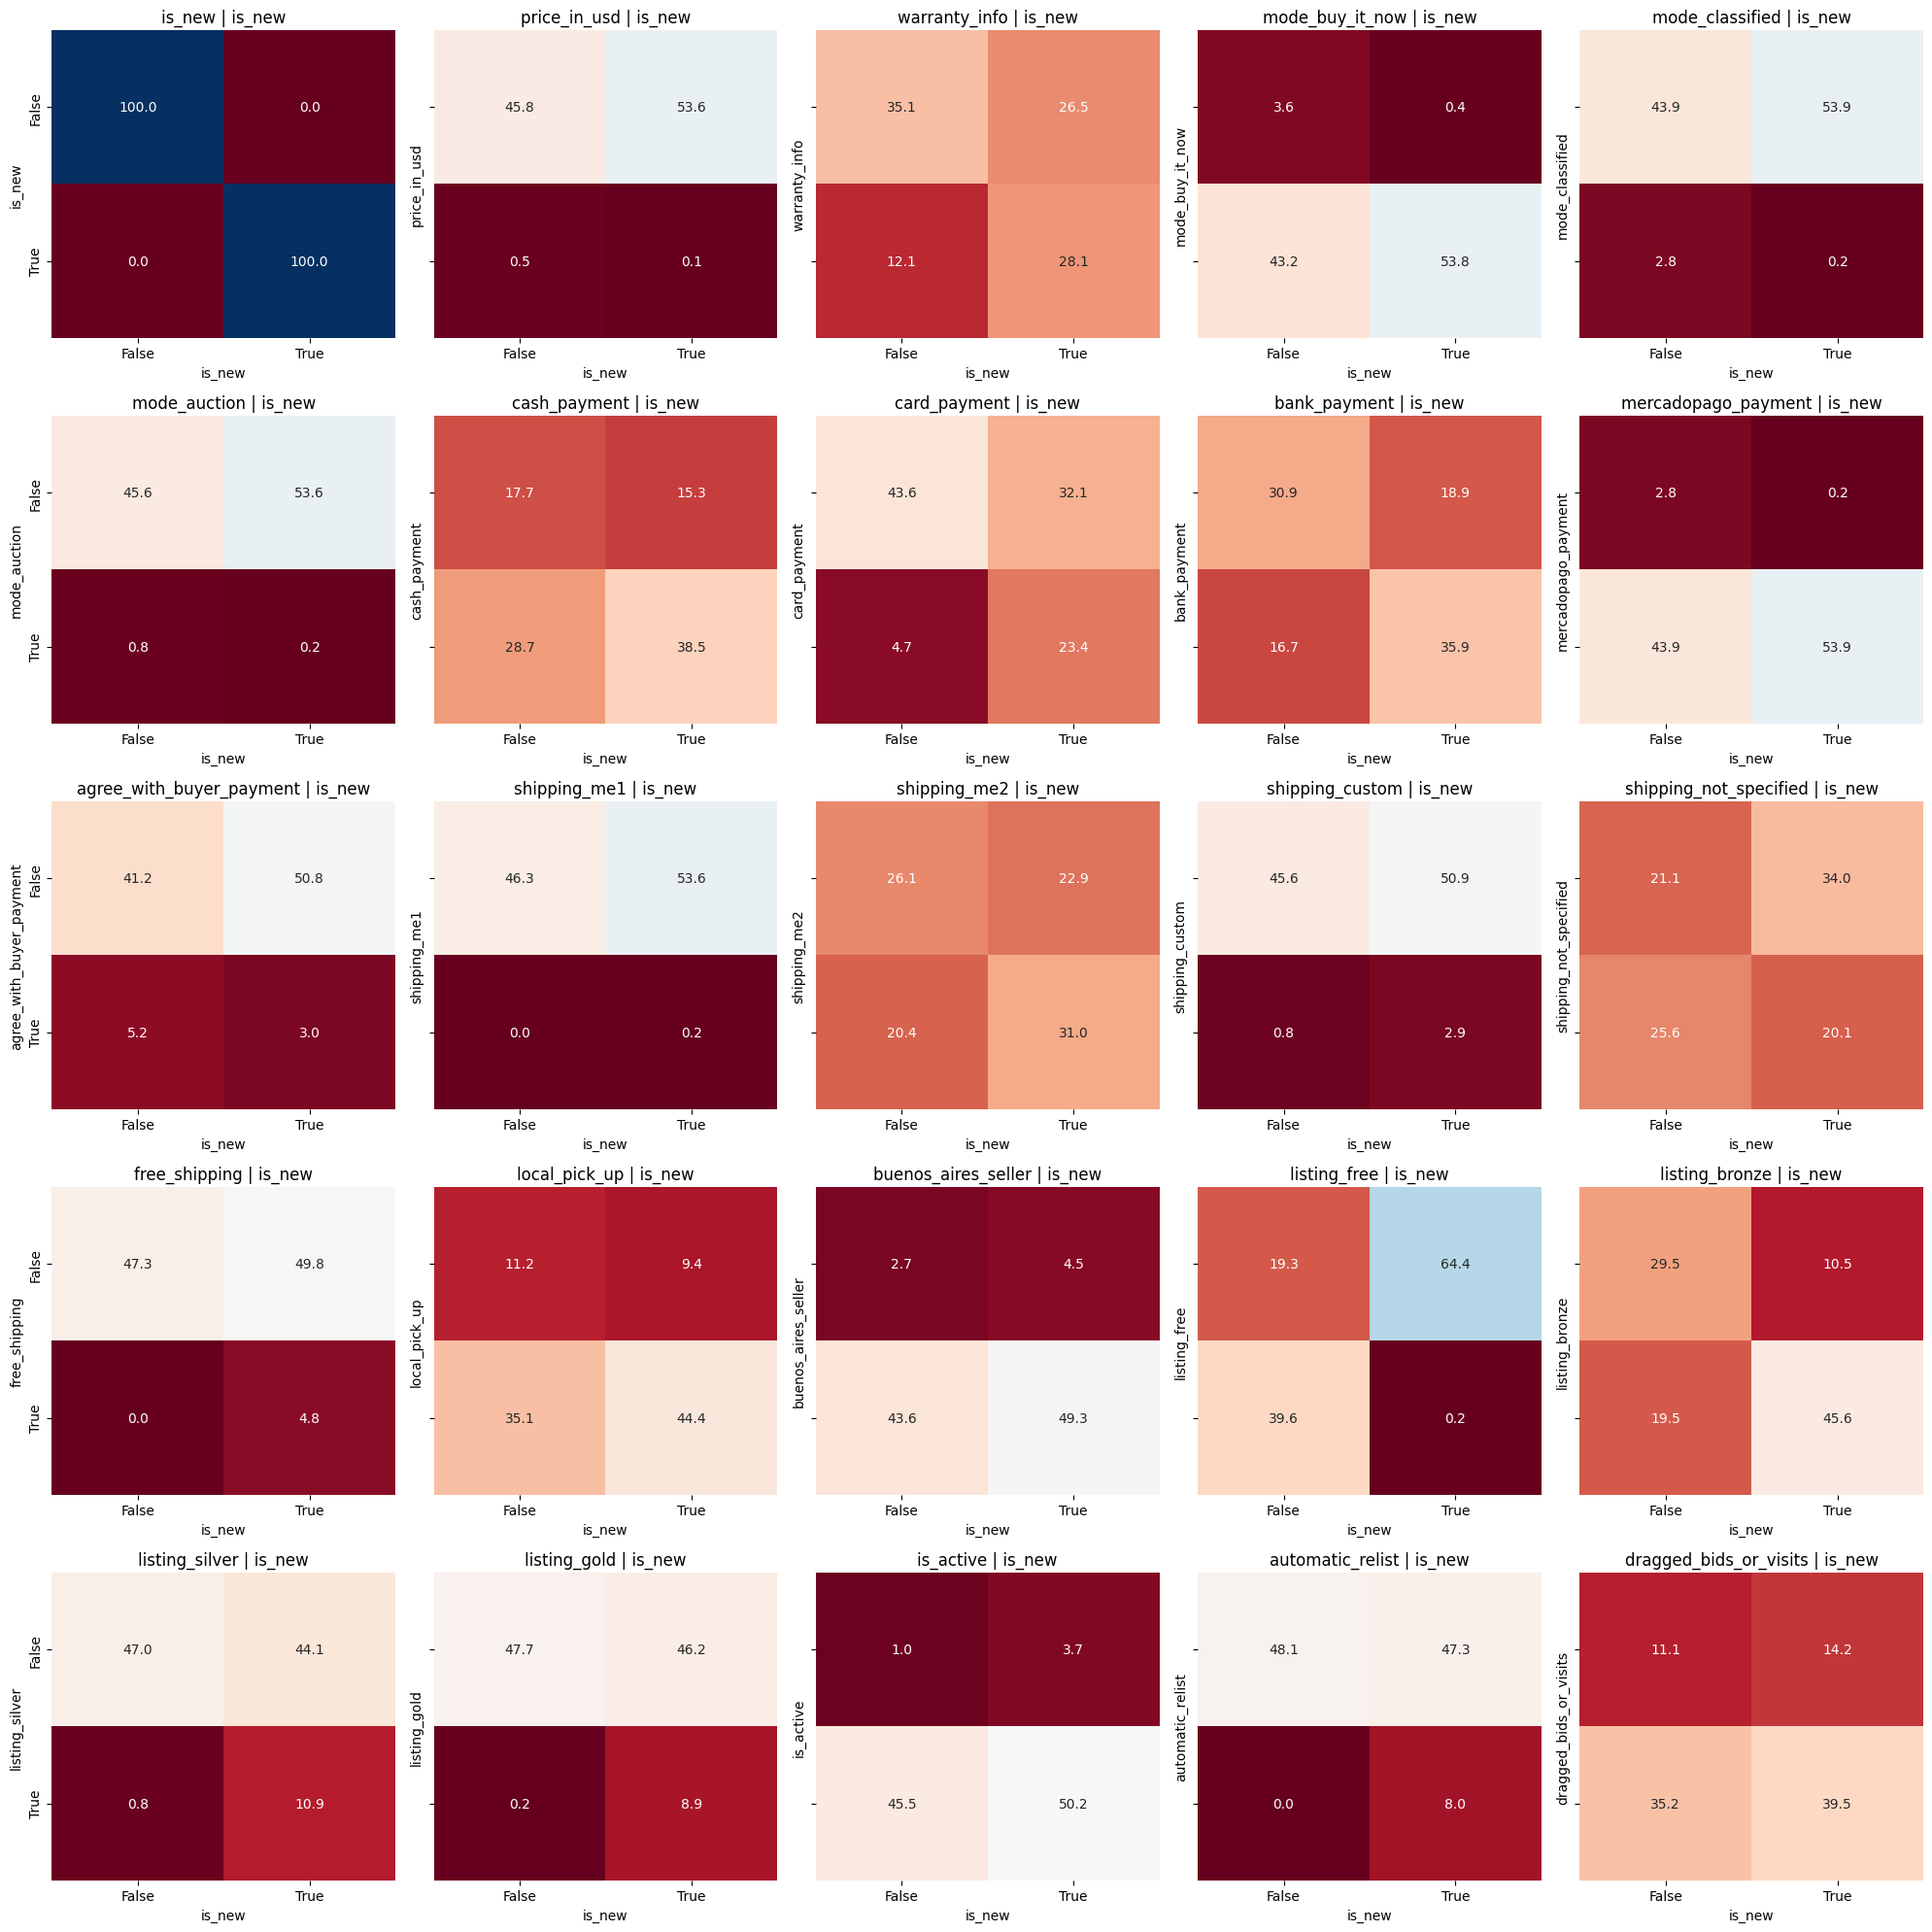

In [6]:
create_subplots(boolean_correlation_heatmap_function, df, target_column + bool_columns, num_rows=5, num_cols=5, title="", fig_size=(20, 20),share_y=True, column_2="is_new")

## Numeric columns

In [7]:
df[numeric_columns].describe()

,price,initial_quantity,sold_quantity,available_quantity,days_active,num_pictures
count,9.000000e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,5.781352e+04,34.957178,2.328044,34.700767,60.924078,2.930322
std,9.089555e+06,421.091981,33.839328,420.811703,38.226420,2.104230
min,8.400000e-01,1.000000,0.000000,1.000000,0.000000,0.000000
25%,9.000000e+01,1.000000,0.000000,1.000000,60.000000,1.000000
50%,2.500000e+02,1.000000,0.000000,1.000000,60.000000,2.000000
75%,8.000000e+02,2.000000,0.000000,2.000000,60.000000,4.000000
max,2.222222e+09,9999.000000,6065.000000,9999.000000,3457.000000,36.000000


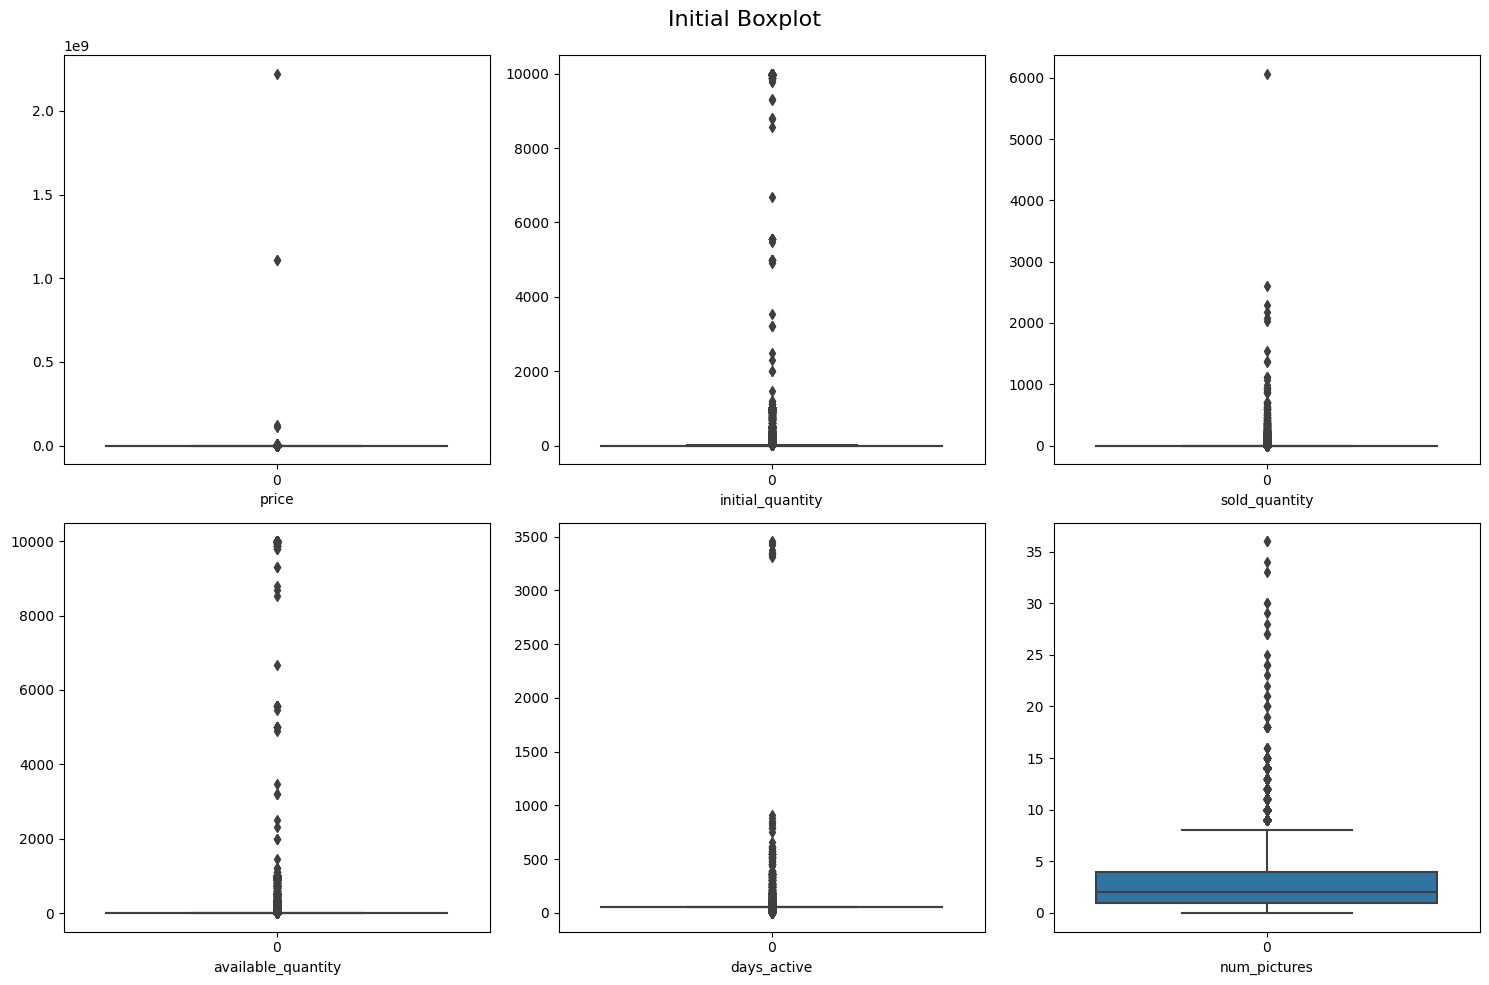

In [8]:
create_subplots(boxplot_function, df, numeric_columns, num_rows=2, num_cols=3, title="Initial Boxplot", fig_size=(15, 10))

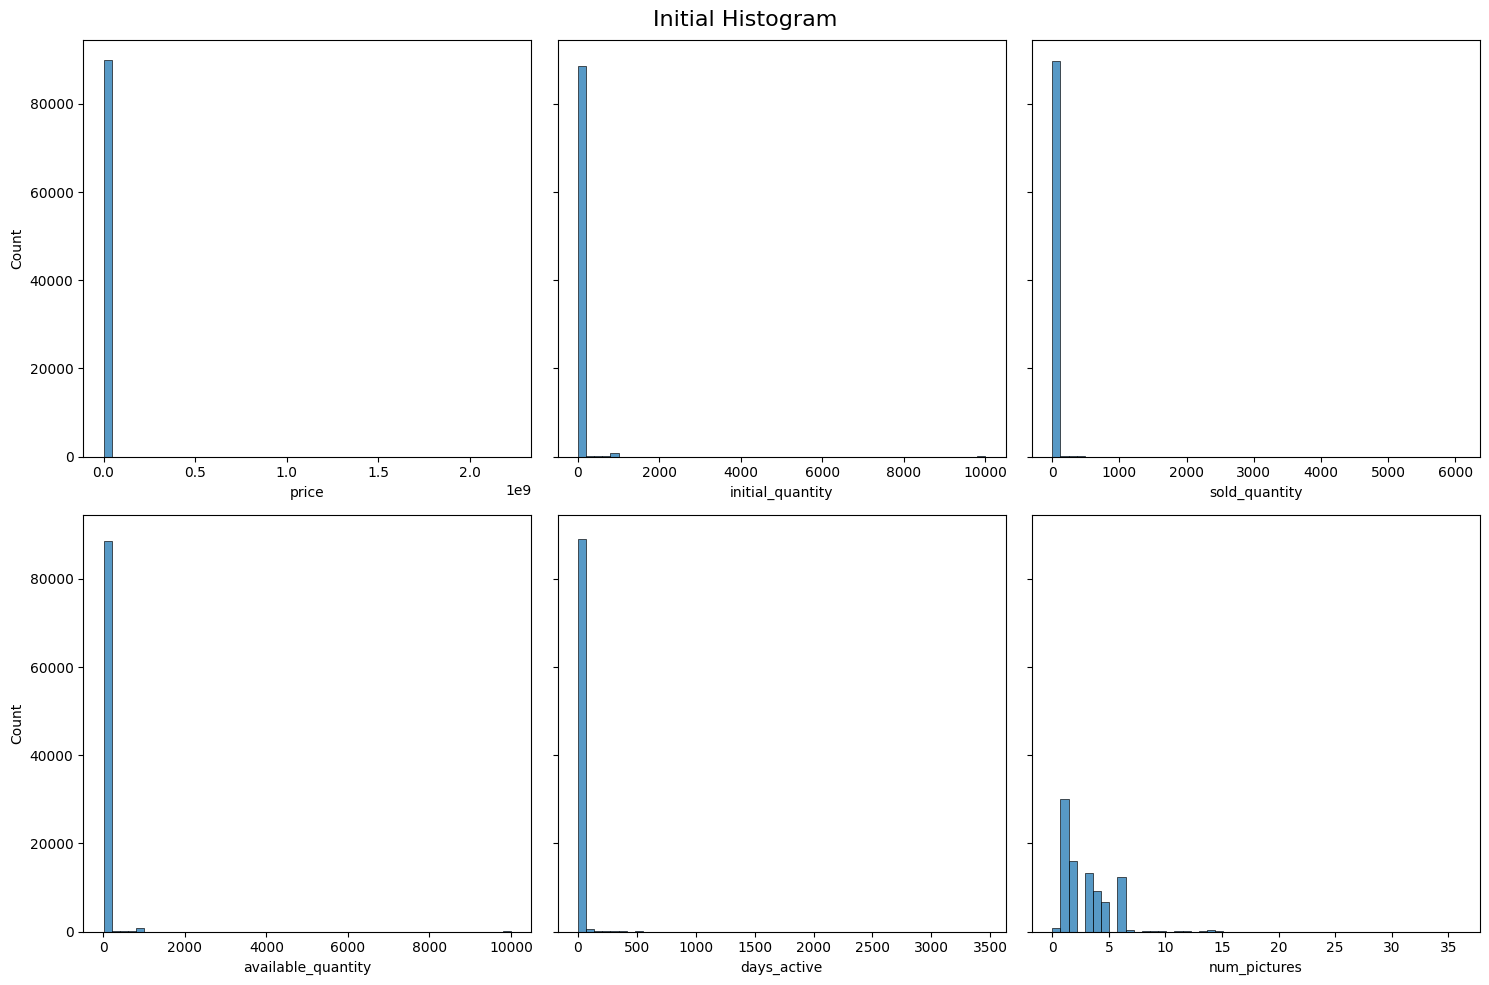

In [9]:
create_subplots(histogram_function, df, numeric_columns, num_rows=2, num_cols=3, title="Initial Histogram", fig_size=(15, 10),share_y=True, bins=50, kde=False)


We will construct a correlation matrix for the numerical columns to identify potential multicollinearity issues. This matrix provides insights into the strength and direction of linear relationships between pairs of variables, aiding in the detection of highly correlated features which may adversely affect certain analyses, such as regression models.

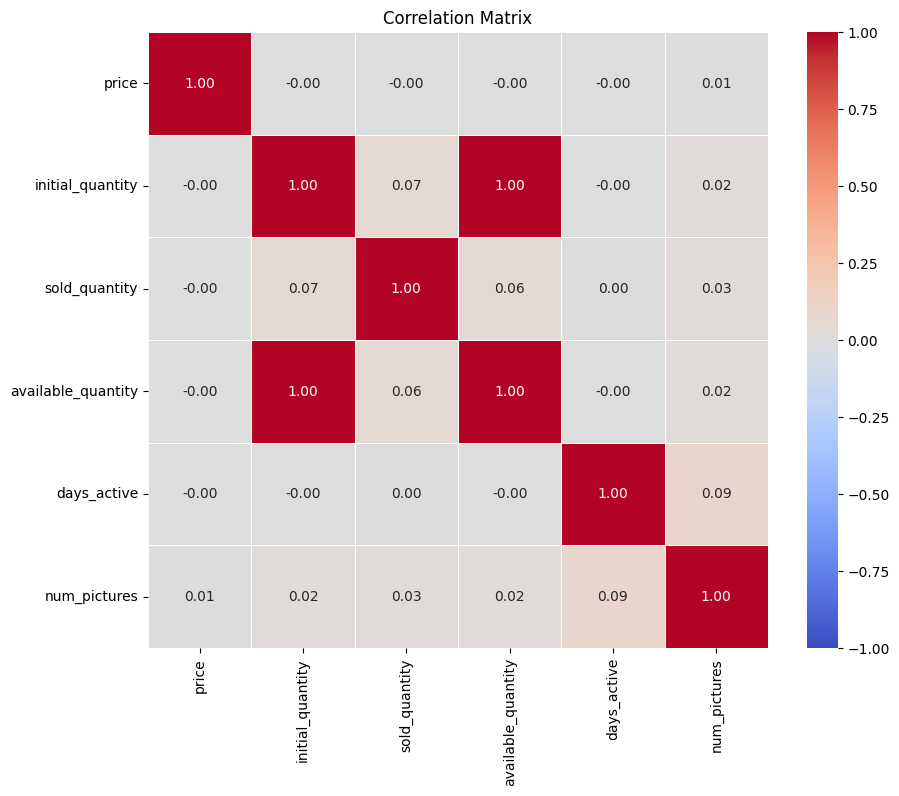

In [10]:
plot_correlation_matrix(df, numeric_columns)

we observed a strong correlation only between 'initial_quantity' and 'available_quantity.' This correlation is primarily attributed to instances where the product remains unsold at the time of data evaluation. However, for the remaining variables, no significant correlations were observed, indicating independence among most features.

## Date columns

For the variable 'start_week', the distribution is concentrated between weeks 32 and 42, while for the variable 'stop_week', the concentration lies between weeks 43 and 52.

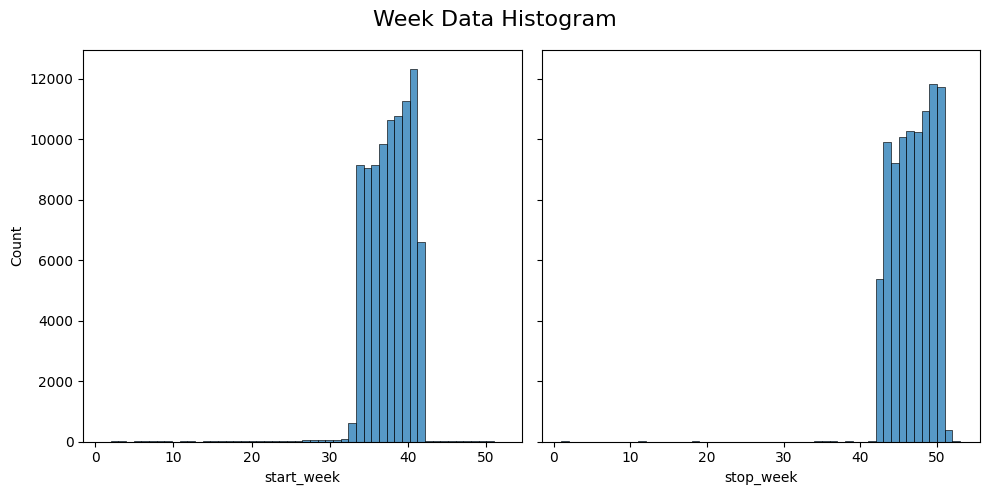

In [11]:
create_subplots(histogram_function, df, ['start_week','stop_week'], num_rows=1, num_cols=2, title="Week Data Histogram", fig_size=(10, 5),share_y=True, bins=52, kde=False)

Regarding 'start_day', its distribution is predominantly concentrated within the initial days of the week, exhibiting contrasting behavior to 'stop_day', where the concentration shifts towards later days of the week.

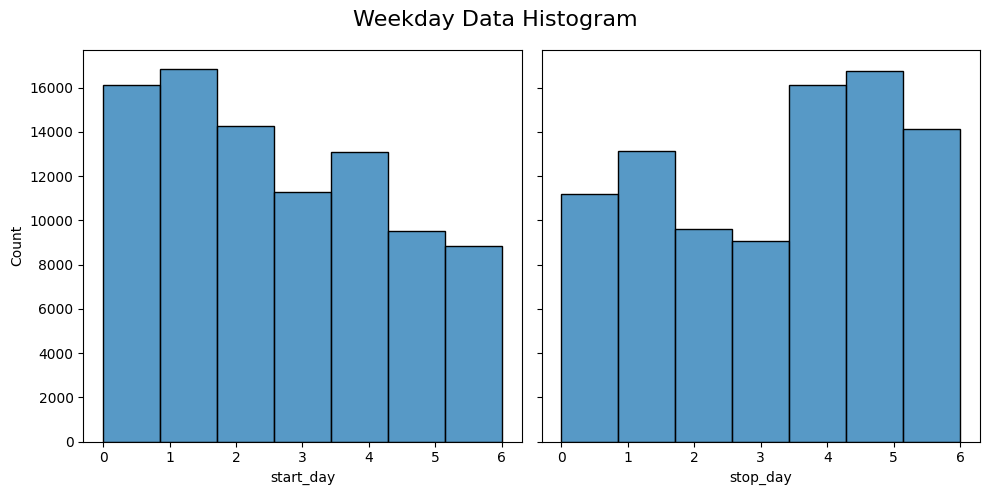

In [12]:
create_subplots(histogram_function, df, ['start_day','stop_day'], num_rows=1, num_cols=2, title="Weekday Data Histogram", fig_size=(10, 5),share_y=True, bins=7, kde=False)

### Outlier detection

The detection of outliers in numerical columns will focus on three key features: 'price', 'days_active', 'initial_quantity', 'sold_quantity' and 'pictures'. 'available_quantity' will not be evaluated directly as it is dependent on 'initial_quantity'. This approach ensures a focused analysis on the core attributes while considering the interdependence among related features.

#### days_active

Range days_active: 0 - 3457


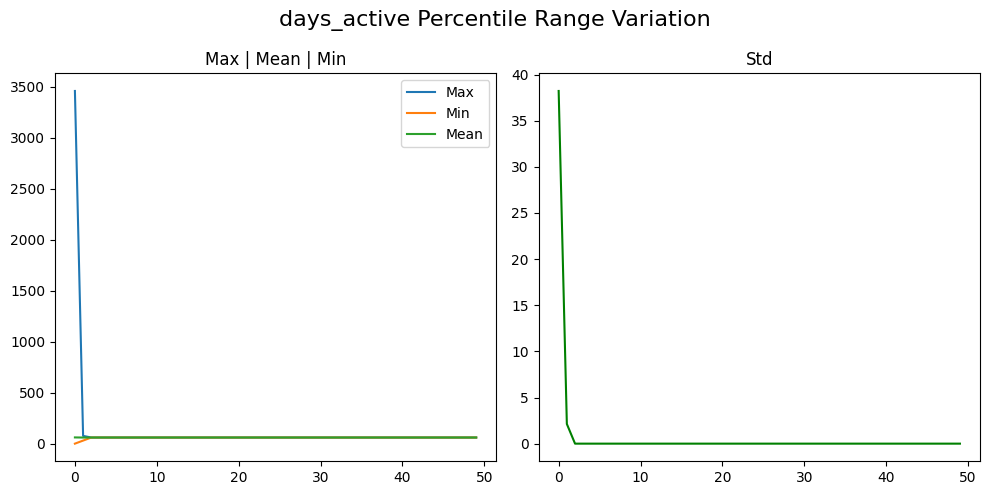

In [13]:
print(f"Range days_active: {df['days_active'].min()} - {df['days_active'].max()}")
plot_percentile_range(df,"days_active",0)

For the variable 'days_active', it is noteworthy that while the data range spans from 0 to 3457, the majority of observations cluster below 100. We will delve deeper into the distribution within the range between different range of percentiles to gain insights into the prevailing trends.

Range days_active p5 - p95 : 60 - 60
Number of observations: 87101


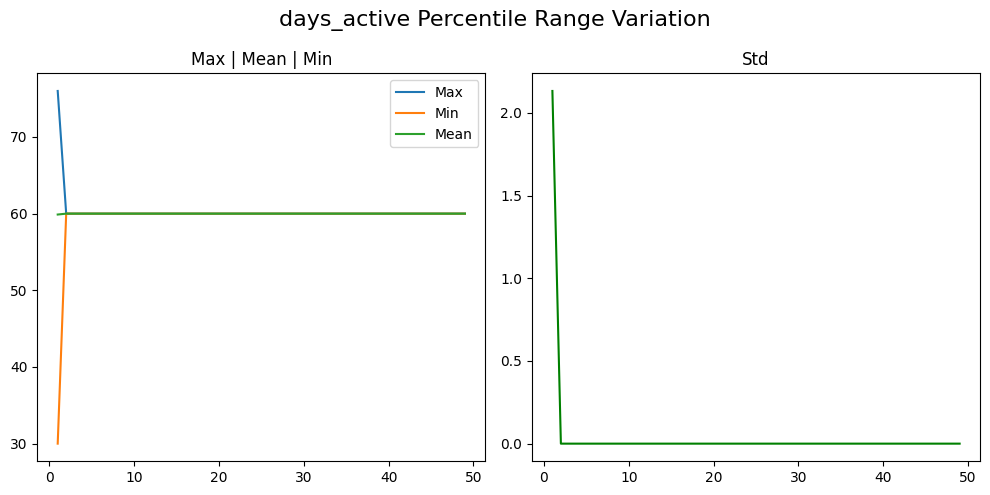

In [14]:
days_active_range = 5
days_active_slice = percentile_range_data(df["days_active"],0+days_active_range,100-days_active_range)
print(f"Range days_active p{0+days_active_range} - p{100-days_active_range} : {days_active_slice.min()} - {days_active_slice.max()}")
print(f"Number of observations: {len(days_active_slice)}")
plot_percentile_range(df,"days_active",1)

Range days_active p5 - p95 : 60 - 60


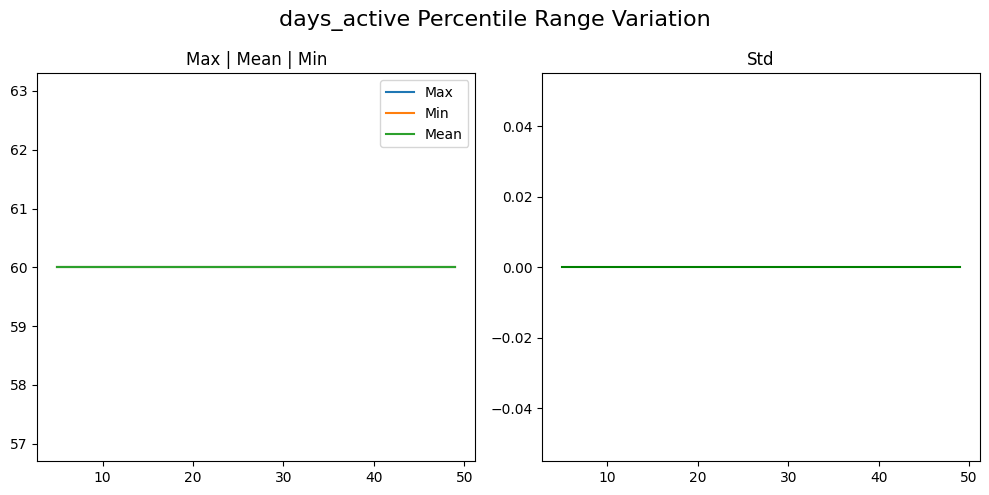

In [15]:
days_active_5_95 = percentile_range_data(df["days_active"],5,95)
print(f"Range days_active p5 - p95 : {days_active_5_95.min()} - {days_active_5_95.max()}")
plot_percentile_range(df,"days_active",5)

Upon analyzing only the values falling within the range of the 5th to 95th percentiles, the 'days_active' variable is observed to be solely 60.

#### price

Range price: 0.84 - 2222222222.0


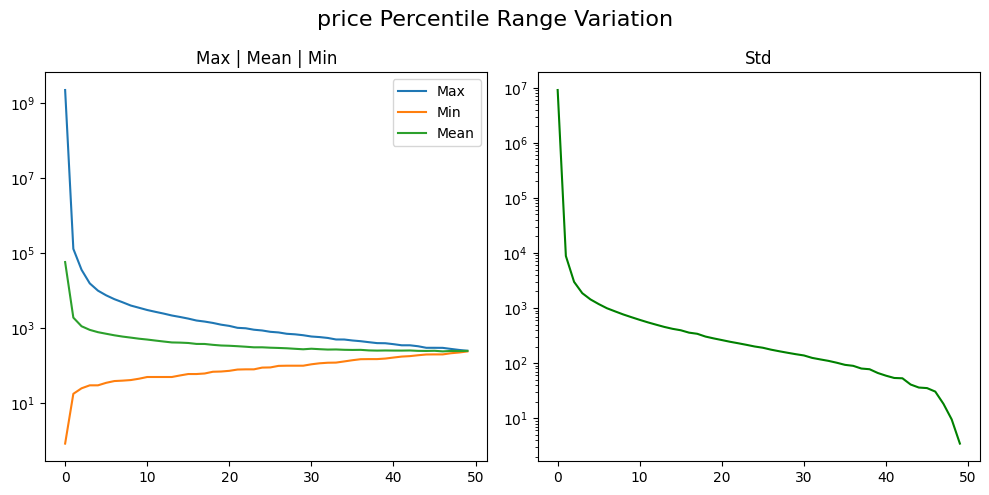

In [16]:
print(f"Range price: {df['price'].min()} - {df['price'].max()}")
plot_percentile_range(df,"price",0,log_scale=True)

For the variable 'price', it is noteworthy that while the data range spans from 0.84 to 2,222,222,222 the majority of observations cluster below 10000. We will delve deeper into the distribution within the range between different range of percentiles to gain insights into the prevailing trends.

Range price p2 - p98 : 24.99 - 36000.0
Number of observations: 86429


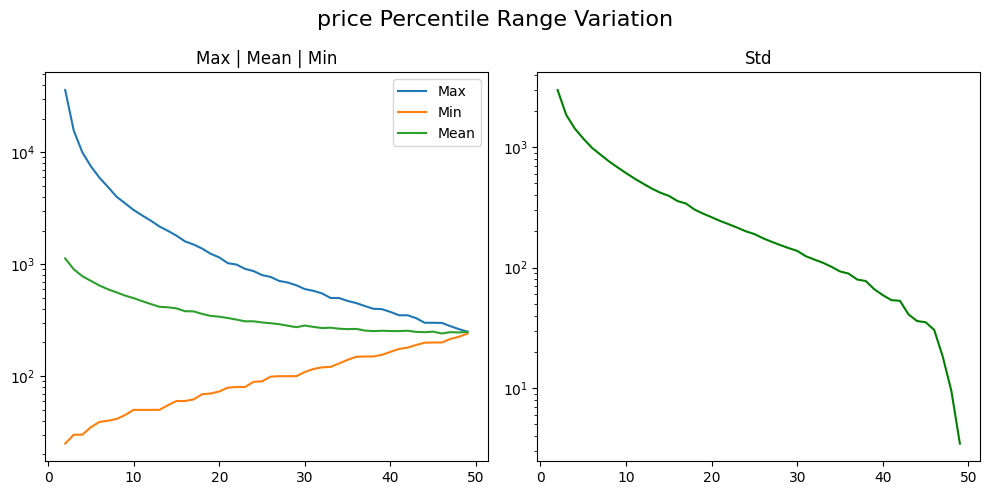

In [17]:
price_range = 2
price_slice = percentile_range_data(df["price"],0+price_range,100-price_range)
print(f"Range price p{0+price_range} - p{100-price_range} : {price_slice.min()} - {price_slice.max()}")
print(f"Number of observations: {len(price_slice)}")
plot_percentile_range(df,"price",price_range,log_scale=True)

Upon analyzing the data, it has been observed that a substantial portion, precisely 96%, of the dataset lies within a fairly compact range spanning from 24.99 to 36000. This indicates a concentrated distribution of values within this interval, suggestive of a coherent pattern or prevailing behavior within the dataset.

#### initial_quantity

Range initial_quantity: 1 - 9999


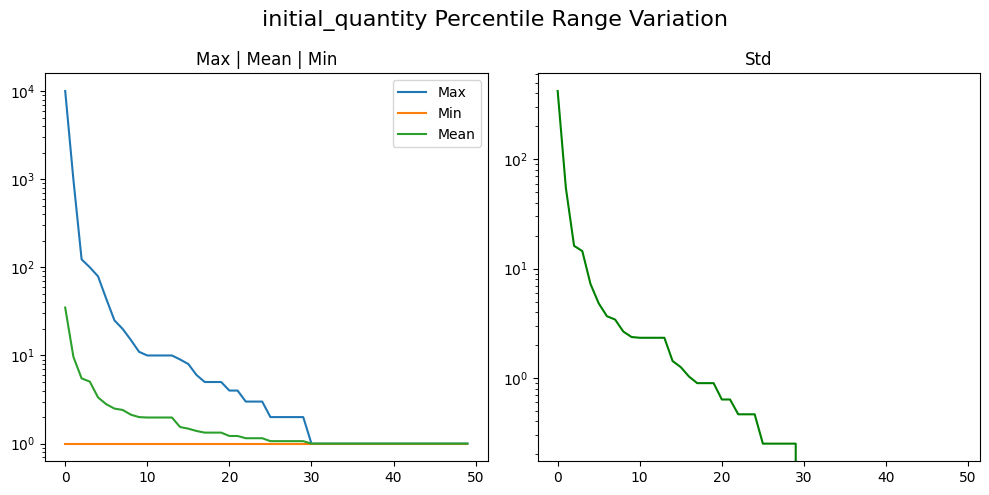

In [18]:
print(f"Range initial_quantity: {df['initial_quantity'].min()} - {df['initial_quantity'].max()}")
plot_percentile_range(df,"initial_quantity",0,log_scale=True)

For the variable 'available_quantity', it is noteworthy that while the data range spans from 1 to 9999 the majority of observations cluster below 100. We will delve deeper into the distribution within the range between different range of percentiles to gain insights into the prevailing trends.

Range initial_quantity p4 - p96 : 1 - 79
Number of observations: 86402


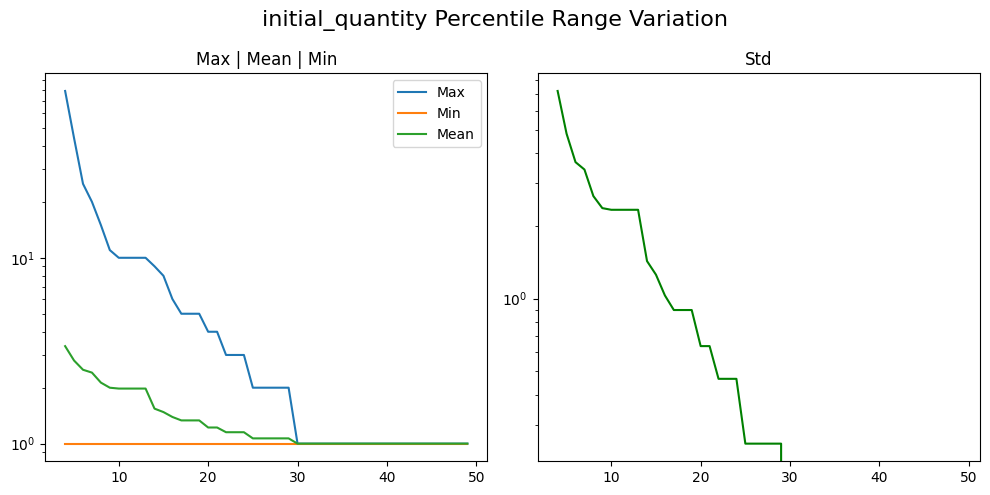

In [19]:
initial_quantity_range = 4
initial_quantity_slice = percentile_range_data(df["initial_quantity"],0+initial_quantity_range,100-initial_quantity_range)
print(f"Range initial_quantity p{0+initial_quantity_range} - p{100-initial_quantity_range} : {initial_quantity_slice.min()} - {initial_quantity_slice.max()}")
print(f"Number of observations: {len(initial_quantity_slice)}")
plot_percentile_range(df,"initial_quantity",initial_quantity_range,log_scale=True)

Upon analyzing the variable "initial_quantity," it's apparent that 40% of the data is represented by a singular value of 1. Moreover, around 80% of the dataset falls within the range of 1 to 5 units, indicating a concentrated distribution. Additionally, the majority of observations (90%) vary between 1 and 10 units, while a significant portion (95%) spans from 1 to 50 units. Notably, a minority of observations (98%) extend from 1 to 150 units, suggesting the presence of outliers. These insights illuminate the variable's distributional nuances and potential impacts on analyses.

#### sold_quantity

Range sold_quantity: 0 - 6065


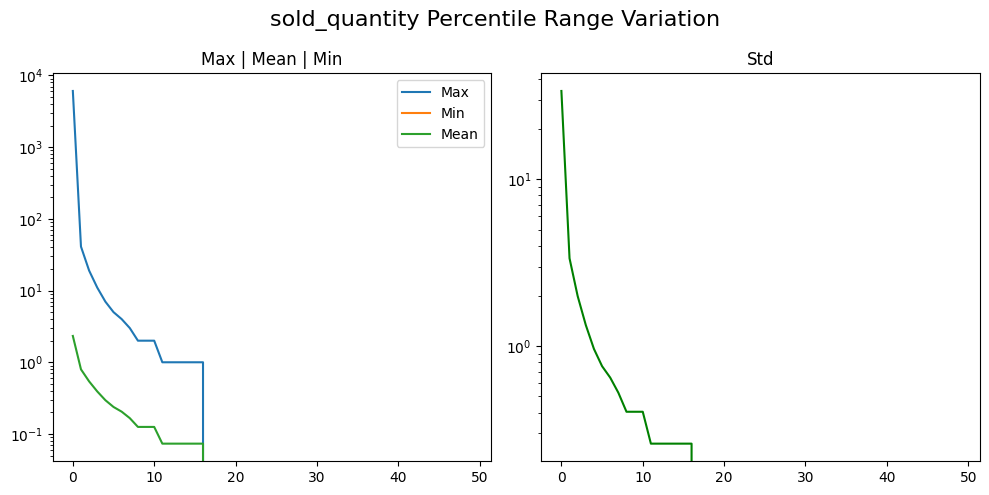

In [20]:
print(f"Range sold_quantity: {df['sold_quantity'].min()} - {df['sold_quantity'].max()}")
plot_percentile_range(df,"sold_quantity",0,log_scale=True)

For the variable 'sold_quantity', it is noteworthy that while the data range spans from 1 to 1540 the majority of observations cluster below 100. We will delve deeper into the distribution within the range between different range of percentiles to gain insights into the prevailing trends.

Range sold_quantity p1 - p99 : 0 - 41
Number of observations: 89108


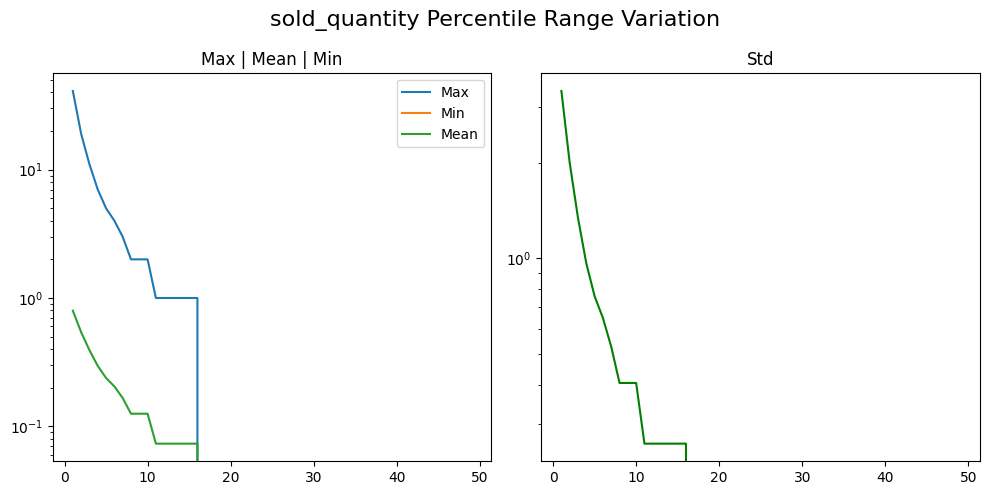

In [21]:
sold_quantity_range = 1
sold_quantity_slice = percentile_range_data(df["sold_quantity"],0+sold_quantity_range,100-sold_quantity_range)
print(f"Range sold_quantity p{0+sold_quantity_range} - p{100-sold_quantity_range} : {sold_quantity_slice.min()} - {sold_quantity_slice.max()}")
print(f"Number of observations: {len(sold_quantity_slice)}")
plot_percentile_range(df,"sold_quantity",sold_quantity_range,log_scale=True)

Upon analyzing the variable "sold_quantity," it's apparent that 98% of the data is below 50.

#### num_pictures

Range num_pictures: 0 - 36


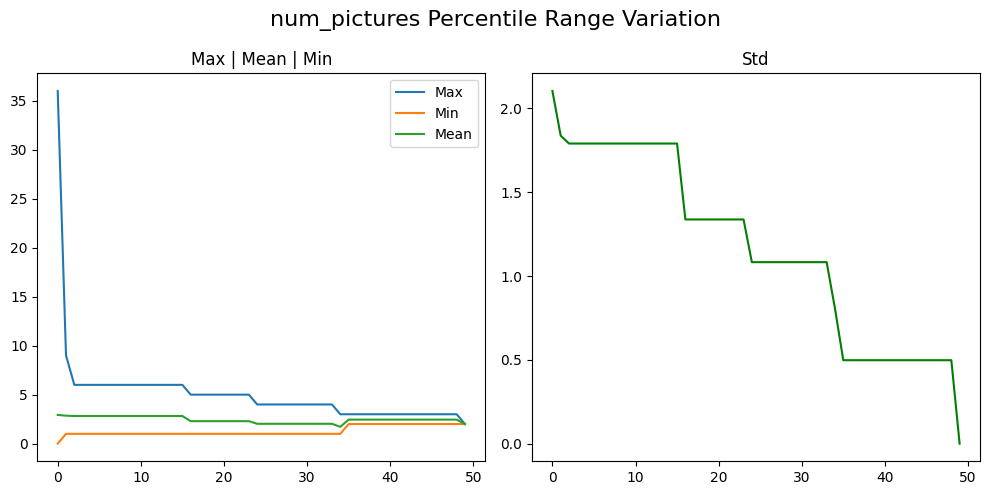

In [22]:
print(f"Range num_pictures: {df['num_pictures'].min()} - {df['num_pictures'].max()}")
plot_percentile_range(df,"num_pictures",0)

For the variable 'num_pictures', the majority of observations cluster below 10. We will delve deeper into the distribution within the range between different range of percentiles to gain insights into the prevailing trends.

Range num_pictures p1 - p99 : 1 - 9
Number of observations: 88429


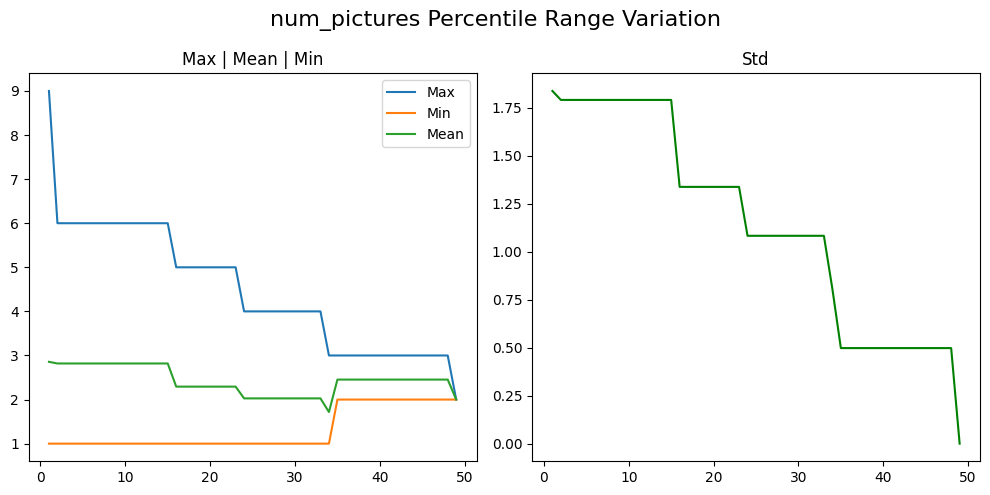

In [23]:
num_pictures_range = 1
num_pictures_slice = percentile_range_data(df["num_pictures"],0+num_pictures_range,100-num_pictures_range)
print(f"Range num_pictures p{0+num_pictures_range} - p{100-num_pictures_range} : {num_pictures_slice.min()} - {num_pictures_slice.max()}")
print(f"Number of observations: {len(num_pictures_slice)}")
plot_percentile_range(df,"num_pictures",num_pictures_range,)

Upon analyzing the variable 'pictures' it's apparent that 98% of the data is below 10.

### Data Refinement and Outlier removal

Initially, we will discard columns exhibiting substantial imbalance as they predominantly offer redundant information that can be distilled from other columns, the "days_active" column, predominantly featuring a single value (60), will be eliminated. Additionally, we'll define operational bounds for "price" and "initial_quantity," facilitating a focused modeling approach within practical limits.

In [24]:
columns_to_remove = ["price_in_usd", "mode_classified", "mode_auction", "shipping_me1", "days_active"]
price_threshold = 50000
initial_quantity_threshold = 150
sold_quantity_threshold = 150
available_quantity_threshold = 150
num_pictures_threshold = 10
df_list = [df,df_2]
for i in df_list:
    for column in columns_to_remove:
        i.drop(columns=[column], inplace=True)

    i.drop(i[i['price'] > price_threshold].index, inplace=True)
    i.drop(i[i['initial_quantity'] > initial_quantity_threshold].index, inplace=True)
    i.drop(i[i['sold_quantity'] > sold_quantity_threshold].index, inplace=True)
    i.drop(i[i['available_quantity'] > available_quantity_threshold].index, inplace=True)
    i.drop(i[i['num_pictures'] > num_pictures_threshold].index, inplace=True)


In [25]:
df.describe()

,price,initial_quantity,sold_quantity,available_quantity,warranty_info,mode_buy_it_now,cash_payment,card_payment,bank_payment,mercadopago_payment,agree_with_buyer_payment,shipping_me2,shipping_custom,shipping_not_specified,free_shipping,local_pick_up,buenos_aires_seller,listing_free,listing_bronze,listing_silver,listing_gold,start_week,start_day,stop_week,stop_day,is_active,num_pictures,automatic_relist,dragged_bids_or_visits,is_new
count,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000
mean,1180.974517,5.575570,1.284527,5.437195,0.394558,0.987419,0.683067,0.254331,0.521382,0.995602,0.081398,0.521116,0.035369,0.442543,0.028691,0.810979,0.928440,0.220259,0.645082,0.082428,0.052232,37.985197,2.584864,46.425217,3.248255,0.958312,2.797333,0.044096,0.753504,0.533812
std,3521.955228,16.416634,7.235506,16.258807,0.488758,0.111456,0.465284,0.435487,0.499545,0.066172,0.273446,0.499557,0.184712,0.496691,0.166938,0.391528,0.257759,0.414423,0.478491,0.275017,0.222496,2.625437,1.950964,2.565901,2.023024,0.199877,1.822999,0.205309,0.430973,0.498858
min,0.840000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,1.000000,44.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,240.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,38.000000,2.000000,47.000000,4.000000,1.000000,2.000000,0.000000,1.000000,1.000000
75%,750.000000,2.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,40.000000,4.000000,49.000000,5.000000,1.000000,4.000000,0.000000,1.000000,1.000000
max,50000.000000,150.000000,148.000000,150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52.000000,6.000000,52.000000,6.000000,1.000000,10.000000,1.000000,1.000000,1.000000


In [26]:
df_2.describe()

,price,initial_quantity,sold_quantity,available_quantity,warranty_info,mode_buy_it_now,cash_payment,card_payment,bank_payment,mercadopago_payment,agree_with_buyer_payment,shipping_me2,shipping_custom,shipping_not_specified,free_shipping,local_pick_up,buenos_aires_seller,listing_free,listing_bronze,listing_silver,listing_gold,start_week,start_day,stop_week,stop_day,is_active,num_pictures,automatic_relist,dragged_bids_or_visits,is_new
count,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000,9586.000000
mean,1211.463254,5.783017,1.374817,5.643230,0.391404,0.987169,0.685062,0.260380,0.524828,0.994784,0.082516,0.530252,0.035573,0.433445,0.031191,0.814834,0.923743,0.218548,0.638535,0.083872,0.059044,37.974233,2.557897,46.410494,3.275923,0.957542,2.810557,0.044857,0.753599,0.537555
std,3543.516019,16.774663,7.548890,16.616318,0.488090,0.112552,0.464516,0.438865,0.499409,0.072037,0.275164,0.499110,0.185232,0.495576,0.173844,0.388452,0.265423,0.413283,0.480450,0.277211,0.235720,2.617876,1.938393,2.552438,2.031602,0.201642,1.824140,0.207001,0.430937,0.498614
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,1.000000,44.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,250.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,38.000000,2.000000,47.000000,4.000000,1.000000,2.000000,0.000000,1.000000,1.000000
75%,800.000000,2.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,40.000000,4.000000,49.000000,5.000000,1.000000,4.000000,0.000000,1.000000,1.000000
max,50000.000000,150.000000,149.000000,150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52.000000,6.000000,52.000000,6.000000,1.000000,10.000000,1.000000,1.000000,1.000000


### Skewness

#### Initial

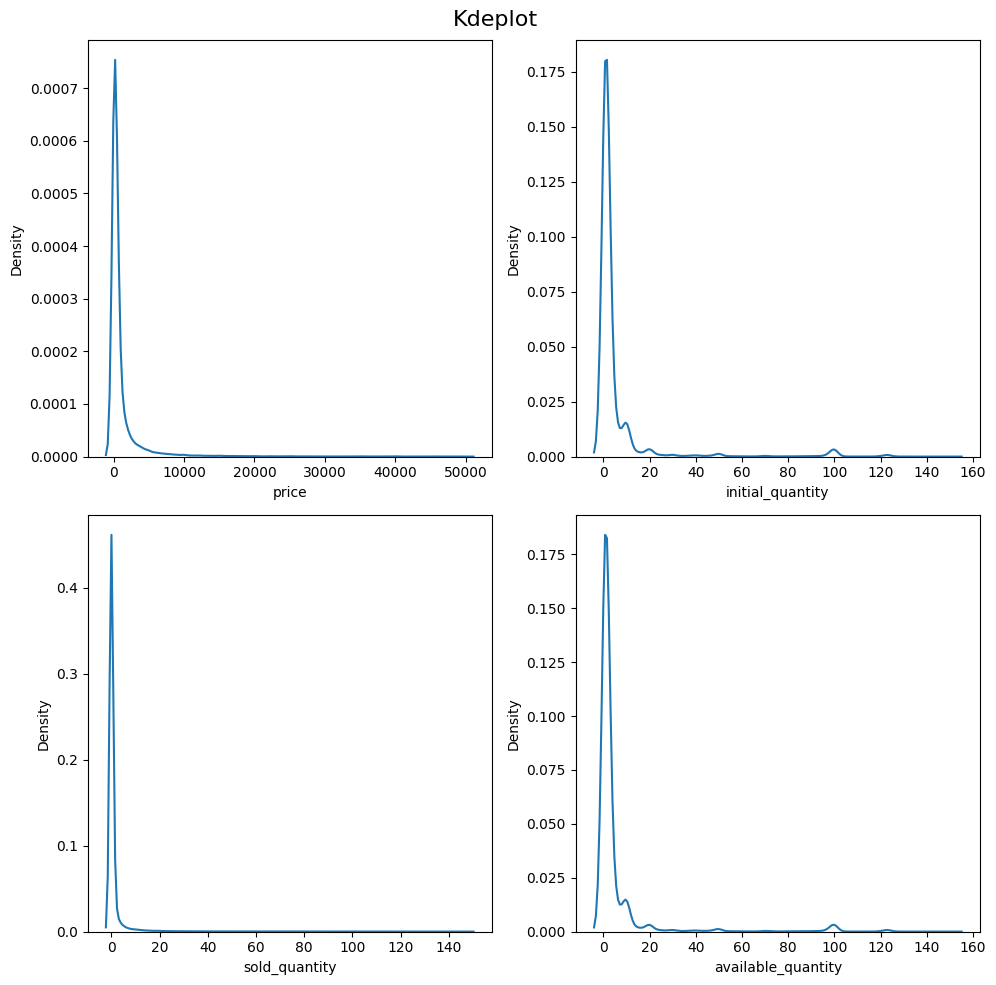

Skewness of price: 7.3
Skewness of prinitial_quantityice: 5.2
Skewness of sold_quantity: 1.1e+01
Skewness of available_quantity: 5.3


In [27]:
create_subplots(kdeplot_function, df, ['price','initial_quantity','sold_quantity','available_quantity'], num_rows=2, num_cols=2, title="Kdeplot", fig_size=(10, 10))
print(f"Skewness of price: {df['price'].skew():.2}")
print(f"Skewness of prinitial_quantityice: {df['initial_quantity'].skew():.2}")
print(f"Skewness of sold_quantity: {df['sold_quantity'].skew():.2}")
print(f"Skewness of available_quantity: {df['available_quantity'].skew():.2}")

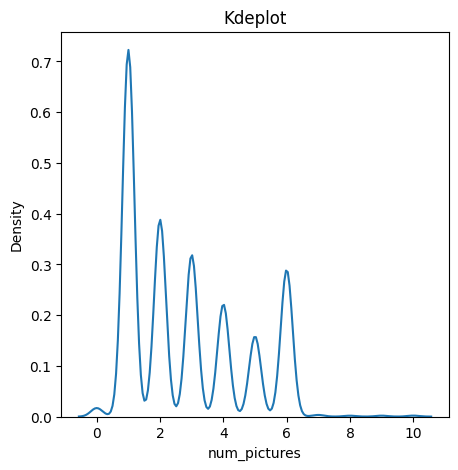

Skewness of num_pictures: 0.66


In [28]:
create_subplots(kdeplot_function, df, ['num_pictures'], num_rows=1, num_cols=1, title="Kdeplot", fig_size=(5, 5))
print(f"Skewness of num_pictures: {df['num_pictures'].skew():.2}")

#### log10

c:\Users\User\.conda\envs\cuda\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


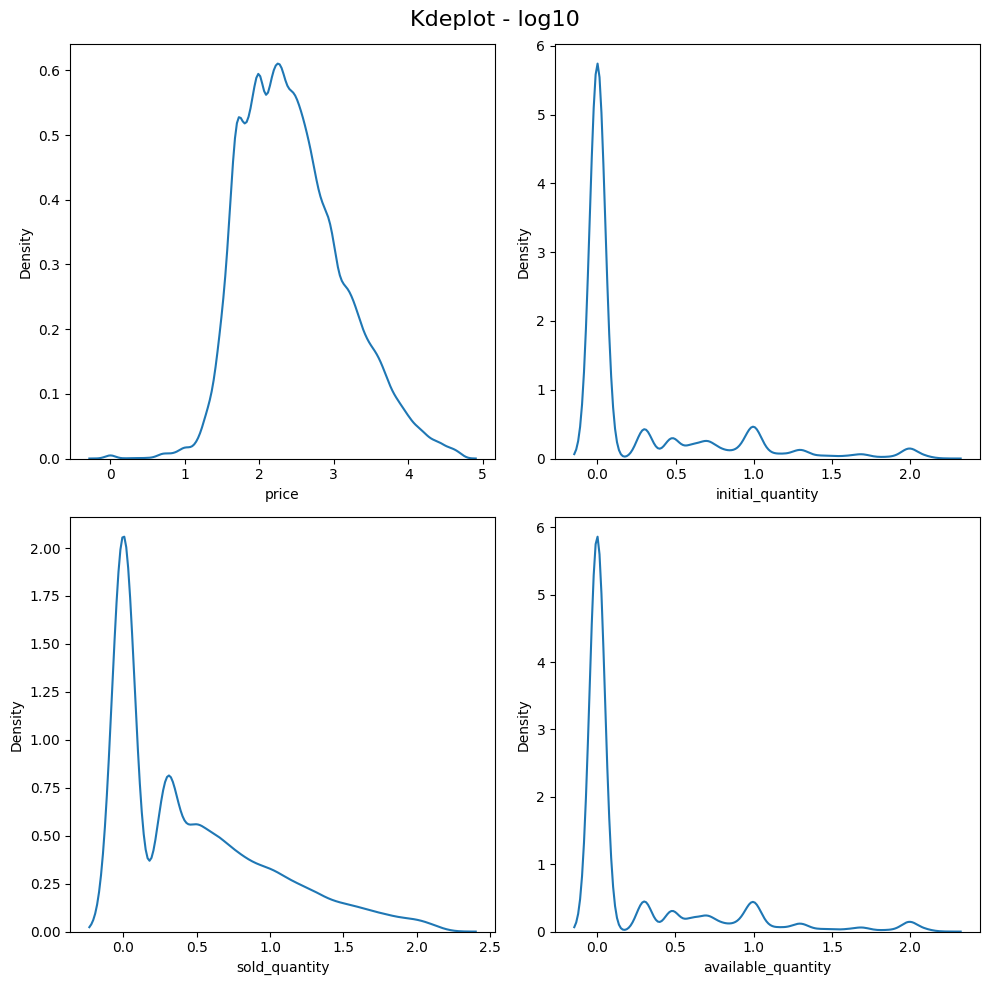

Skewness of price: 0.523
Skewness of initial_quantity: 2.01
Skewness of sold_quantity: nan
Skewness of available_quantity: 2.08


In [29]:
df_skew = df[['price','initial_quantity','sold_quantity','available_quantity']].copy(deep=True)

df_skew['price'] = np.log10(df_skew['price'])
df_skew['initial_quantity'] = np.log10(df_skew['initial_quantity'])
df_skew['sold_quantity'] = np.log10(df_skew['sold_quantity'])
df_skew['available_quantity'] = np.log10(df_skew['available_quantity'])

create_subplots(kdeplot_function, df_skew, ['price','initial_quantity','sold_quantity','available_quantity'], num_rows=2, num_cols=2, title="Kdeplot - log10", fig_size=(10, 10))
print(f"Skewness of price: {df_skew['price'].skew():.3}")
print(f"Skewness of initial_quantity: {df_skew['initial_quantity'].skew():.3}")
print(f"Skewness of sold_quantity: {df_skew['sold_quantity'].skew():.3}")
print(f"Skewness of available_quantity: {df_skew['available_quantity'].skew():.3}")

#### yeojohnson

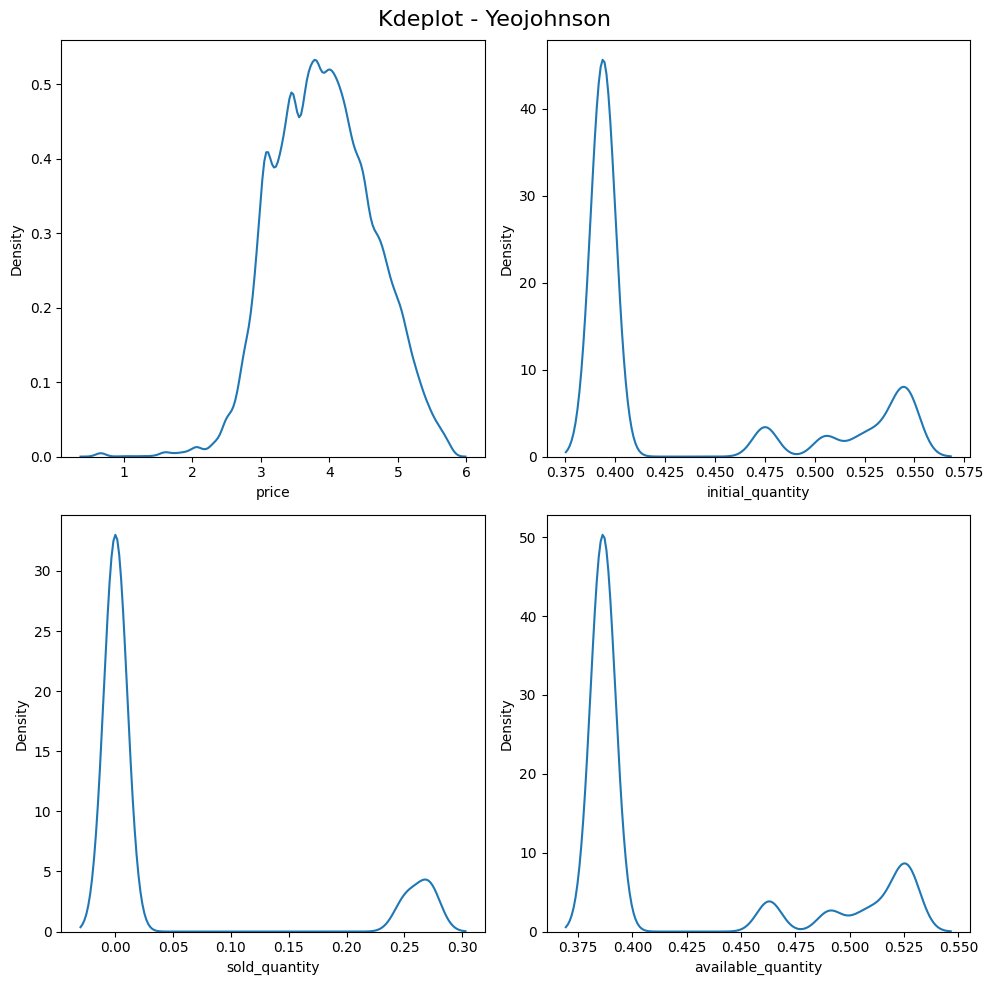

Skewness of price: 0.014
Skewness of initial_quantity: 1.09
Skewness of sold_quantity: 1.8
Skewness of available_quantity: 1.12


In [30]:
df_skew = df[['price','initial_quantity','sold_quantity','available_quantity']].copy(deep=True)

yj_price = yeojohnson(df_skew["price"])[1]
yj_initial_quantity = yeojohnson(df_skew["initial_quantity"])[1]
yj_sold_quantity = yeojohnson(df_skew["sold_quantity"])[1]
yj_available_quantity = yeojohnson(df_skew["available_quantity"])[1]

df_skew['price'] = yeojohnson(df_skew['price'],yj_price)
df_skew['initial_quantity'] = yeojohnson(df_skew['initial_quantity'],yj_initial_quantity)
df_skew['sold_quantity'] = yeojohnson(df_skew['sold_quantity'],yj_sold_quantity)
df_skew['available_quantity'] = yeojohnson(df_skew['available_quantity'],yj_available_quantity)

create_subplots(kdeplot_function, df_skew, ['price','initial_quantity','sold_quantity','available_quantity'], num_rows=2, num_cols=2, title="Kdeplot - Yeojohnson", fig_size=(10, 10))
print(f"Skewness of price: {df_skew['price'].skew():.3}")
print(f"Skewness of initial_quantity: {df_skew['initial_quantity'].skew():.3}")
print(f"Skewness of sold_quantity: {df_skew['sold_quantity'].skew():.3}")
print(f"Skewness of available_quantity: {df_skew['available_quantity'].skew():.3}")

In [31]:
print(yj_price) 
print(yj_initial_quantity)
print(yj_sold_quantity)
print(yj_available_quantity)

-0.13176445908469758
-1.8193939424626555
-3.666871457671417
-1.888688928016593


### Scale and Normalize

In [32]:
yj_price = -0.1326933439177492
yj_initial_quantity = -1.8163258668093907
yj_sold_quantity = -3.65996684652743
yj_available_quantity = -1.8854981114246059

for i in range(len(df_list)):
    df_list[i]['price'] = yeojohnson(df_list[i]['price'], yj_price)
    df_list[i]['initial_quantity'] = yeojohnson(df_list[i]['initial_quantity'], yj_initial_quantity)
    df_list[i]['sold_quantity'] = yeojohnson(df_list[i]['sold_quantity'], yj_sold_quantity)
    df_list[i]['available_quantity'] = yeojohnson(df_list[i]['available_quantity'], yj_available_quantity)


In [33]:
df.describe()

,price,initial_quantity,sold_quantity,available_quantity,warranty_info,mode_buy_it_now,cash_payment,card_payment,bank_payment,mercadopago_payment,agree_with_buyer_payment,shipping_me2,shipping_custom,shipping_not_specified,free_shipping,local_pick_up,buenos_aires_seller,listing_free,listing_bronze,listing_silver,listing_gold,start_week,start_day,stop_week,stop_day,is_active,num_pictures,automatic_relist,dragged_bids_or_visits,is_new
count,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000,86403.000000
mean,3.906315,0.431712,0.043685,0.420649,0.394558,0.987419,0.683067,0.254331,0.521382,0.995602,0.081398,0.521116,0.035369,0.442543,0.028691,0.810979,0.928440,0.220259,0.645082,0.082428,0.052232,37.985197,2.584864,46.425217,3.248255,0.958312,2.797333,0.044096,0.753504,0.533812
std,0.707750,0.060671,0.098099,0.055468,0.488758,0.111456,0.465284,0.435487,0.499545,0.066172,0.273446,0.499557,0.184712,0.496691,0.166938,0.391528,0.257759,0.414423,0.478491,0.275017,0.222496,2.625437,1.950964,2.565901,2.023024,0.199877,1.822999,0.205309,0.430973,0.498858
min,0.585749,0.394234,-0.000000,0.386821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.394278,0.394234,-0.000000,0.386821,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,1.000000,44.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,3.896410,0.394234,0.000000,0.386821,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,38.000000,2.000000,47.000000,4.000000,1.000000,2.000000,0.000000,1.000000,1.000000
75%,4.405969,0.475711,-0.000000,0.463535,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,40.000000,4.000000,49.000000,5.000000,1.000000,4.000000,0.000000,1.000000,1.000000
max,5.742977,0.550501,0.273227,0.530323,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52.000000,6.000000,52.000000,6.000000,1.000000,10.000000,1.000000,1.000000,1.000000


In [34]:
scaler = DataScaler()
X_train_scaled = df.drop(columns=['is_new']).copy(deep=True)
y_train_scaled = df[['is_new']].copy(deep=True)
X_test_scaled = df_2.drop(columns=['is_new']).copy(deep=True)
y_test_scaled = df_2[['is_new']].copy(deep=True)

In [35]:
X_train_scaled = scaler.fit_transform(X_train_scaled)

In [36]:
X_test_scaled = scaler.transform(X_test_scaled)

In [ ]:
# visualize_pca(X_train_scaled, y_train_scaled)

In [ ]:
if False:
    X_train_scaled.to_csv("../data/processed/train_data.csv", index=False)
    y_train_scaled.to_csv("../data/processed/train_target.csv", index=False)
    X_test_scaled.to_csv("../data/processed/test_data.csv", index=False)
    y_test_scaled.to_csv("../data/processed/test_target.csv", index=False)

--------------------------------